In [179]:
import tensorflow as tf
import pandas as pd
import os
from fast_ml.model_development import train_valid_test_split
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

%matplotlib inline
sns.set()

In [180]:
# Set memory limiter for each GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [181]:
data_path = os.path.join("dataset", "GGU_price_predict.csv")
data_df = pd.read_csv(data_path)

In [182]:
data_df.sample(3)

,label,price,est_meters,est_duration
15028,0,0.5,10423,938
1838,1,3.1,4938,444
14120,0,0.5,26,2


In [183]:
scaled_df = data_df
scaler = MinMaxScaler()
scaled_df[["est_meters", "est_duration"]] = scaler.fit_transform(scaled_df[["est_meters", "est_duration"]])

In [184]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(scaled_df, target = 'label', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42)

In [185]:
# oversampling to handle label imbalance
oversample = SMOTETomek(random_state = 42)
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
X_valid_sm, y_valid_sm = oversample.fit_resample(X_valid, y_valid)

Reconstruct the dataframe without price scale

In [186]:
label_df = pd.DataFrame({"label" : y_train_sm})
new_train = pd.concat([X_train_sm, label_df], axis=1)
X_train_new, y_train_new = new_train[["label", "est_meters", "est_duration"]], new_train["price"]

In [187]:
label_df = pd.DataFrame({"label" : y_valid_sm})
new_valid = pd.concat([X_valid_sm, label_df], axis=1)
X_valid_new, y_valid_new = new_valid[["label", "est_meters", "est_duration"]], new_valid["price"]

In [188]:
label_df = pd.DataFrame({"label" : y_test})
new_test = pd.concat([X_test, label_df], axis=1)
X_test_new, y_test_new = new_valid[["label", "est_meters", "est_duration"]], new_valid["price"]

#### Model

In [189]:
X_train_new.shape

(54318, 3)

In [254]:
csv_log = tf.keras.callbacks.CSVLogger(
    os.path.join("models", "history.csv"), 
    separator=",", 
    append=False
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=1,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [274]:
KR = tf.keras.regularizers.L2(
    l2=0.0001
)

model = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(512, input_shape=(3, )),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [275]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="mean_absolute_error",
)

In [276]:
history = model.fit(
    X_train_new, y_train_new,
    validation_data = (X_valid_new, y_valid_new),
    batch_size=32,
    epochs=100, 
    verbose = 1,
    callbacks = [earlystop, csv_log]
)

Epoch 1/100
1698/1698 [==============================] - 17s 10ms/step - loss: 0.7770 - val_loss: 0.6378
Epoch 2/100
1698/1698 [==============================] - 18s 10ms/step - loss: 0.6903 - val_loss: 0.6350
Epoch 3/100
1698/1698 [==============================] - 19s 11ms/step - loss: 0.6810 - val_loss: 0.6355
Epoch 4/100
1698/1698 [==============================] - 17s 10ms/step - loss: 0.6753 - val_loss: 0.6376
Epoch 5/100
1698/1698 [==============================] - 17s 10ms/step - loss: 0.6713 - val_loss: 0.6403
Epoch 6/100
1698/1698 [==============================] - 18s 11ms/step - loss: 0.6697 - val_loss: 0.6399
Epoch 7/100
1698/1698 [==============================] - 18s 10ms/step - loss: 0.6671 - val_loss: 0.6337
Epoch 8/100
1698/1698 [==============================] - 18s 11ms/step - loss: 0.6666 - val_loss: 0.6325
Epoch 9/100
1698/1698 [==============================] - 16s 9ms/step - loss: 0.6665 - val_loss: 0.6344
Epoch 10/100
1698/1698 [==============================] 

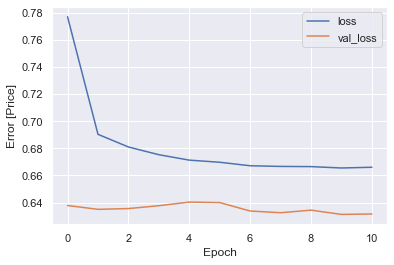

In [277]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()


In [278]:
val_pred = model.predict(X_valid_new)

209/209 [==============================] - 1s 3ms/step


In [279]:
r2_score(list(y_valid_new), val_pred)

0.5325754902582436

In [280]:
mean_squared_error(list(y_valid_new), val_pred)

0.8853526718157851

In [281]:
np.sqrt(mean_squared_error(list(y_valid_new), val_pred))

0.9409318103963672

In [284]:
model.save(os.path.join("models", "GGU_3_Price_predict.h5"))

In [308]:
test_pred = model.predict(X_test)
test_result = []
for pred in test_pred :
    test_result.append(float(test_pred[0]))

133/133 [==============================] - 0s 3ms/step


In [311]:
test_df = pd.DataFrame({"price" : test_result})
test_report = pd.concat([X_test.reset_index(), test_df], axis=1, ignore_index=True)
test_report.to_csv(os.path.join("assets", "GGU_price_predict_report.csv"), index=False)

Sorry ill not optimize this yet, ga cukup waktunya sampe jam 11 tgl 27 wkwkwk

In [313]:
!jupyter-nbconvert --to PDFviaHTML price_est_model.ipynb

[NbConvertApp] Converting notebook price_est_model.ipynb to PDFviaHTML
[NbConvertApp] Writing 270437 bytes to price_est_model.pdf
